In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


In [2]:
# simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
# Settings for experiment
num_epochs = 9  # Training for 9 epochs and capturing weights every 3 epochs
num_trainings = 8  # Training model 8 times
pca = PCA(n_components=2)  # For dimensionality reduction

In [6]:
# Storage for weights, loss, and accuracy
layer_weight_records = []
whole_model_weight_records = []
accuracy_records = []

def collect_layer_weights(model, layer_name):
    """Collect weights of a specific layer"""
    layer = dict(model.named_parameters())[layer_name]
    return layer.view(-1).detach().numpy()

def collect_whole_model_weights(model):
    """Collect all weights in the model"""
    weights = []
    for param in model.parameters():
        weights.append(param.view(-1).detach().numpy())
    return np.concatenate(weights)

In [7]:
def train_and_collect_weights():
    all_layer_weights = []
    all_whole_model_weights = []
    all_accuracies = []
    
    for training in range(num_trainings):
        model = SimpleNN()  # Reset model
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for images, labels in trainloader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            # Collect weights and accuracy every 3 epochs
            if (epoch + 1) % 3 == 0:
                # Collect weights of the single layer 
                layer_weights = collect_layer_weights(model, 'fc1.weight')
                all_layer_weights.append(layer_weights)
                
                # Collect weights of the entire model
                whole_model_weights = collect_whole_model_weights(model)
                all_whole_model_weights.append(whole_model_weights)
                
                accuracy = correct / total
                all_accuracies.append(accuracy)
    
    return all_layer_weights, all_whole_model_weights, all_accuracies


In [8]:
# Train and collect weights and accuracies
for _ in range(num_trainings):
    layer_weights, whole_model_weights, accuracies = train_and_collect_weights()
    layer_weight_records.append(layer_weights)
    whole_model_weight_records.append(whole_model_weights)
    accuracy_records.append(accuracies)


In [9]:
# Reshape for PCA
all_layer_weights_flattened = np.vstack(layer_weight_records)
all_whole_model_weights_flattened = np.vstack(whole_model_weight_records)

pca_layer = PCA(n_components=2)
pca_whole = PCA(n_components=2)

pca_layer_result = pca_layer.fit_transform(all_layer_weights_flattened)
pca_whole_model_result = pca_whole.fit_transform(all_whole_model_weights_flattened)


In [10]:
# Plot the PCA results for the single layer
def plot_pca(pca_result, accuracy_records, title):
    plt.figure(figsize=(10, 6))
    
    num_points_per_training = len(accuracy_records[0])
    for training in range(num_trainings):
        start_idx = training * num_points_per_training
        end_idx = start_idx + num_points_per_training
        
        plt.scatter(pca_result[start_idx:end_idx, 0], pca_result[start_idx:end_idx, 1], 
                    label=f'Training {training + 1}', cmap='viridis')
        
        for i in range(start_idx, end_idx):
            plt.text(pca_result[i, 0], pca_result[i, 1], f'{accuracy_records[training][i-start_idx]:.2f}')
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

C:\Users\ADITYA MORE\AppData\Local\Temp\ipykernel_12608\2936058651.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[start_idx:end_idx, 0], pca_result[start_idx:end_idx, 1],


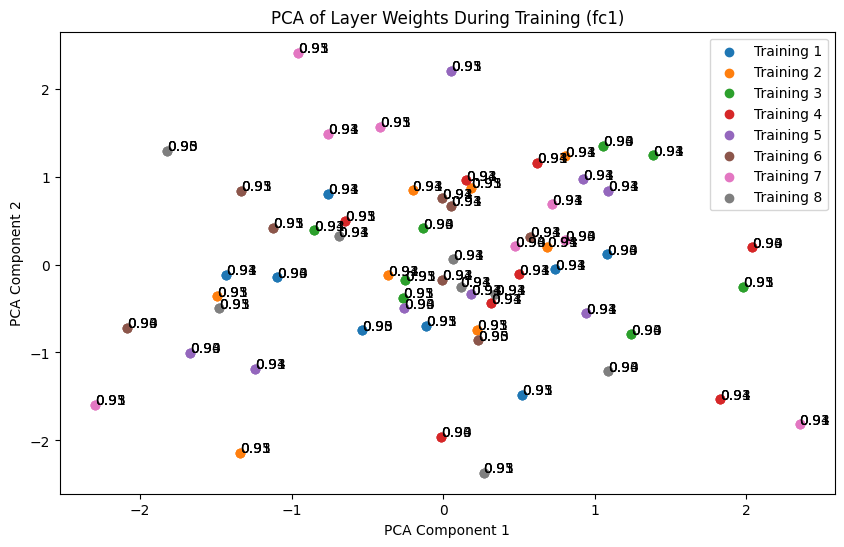

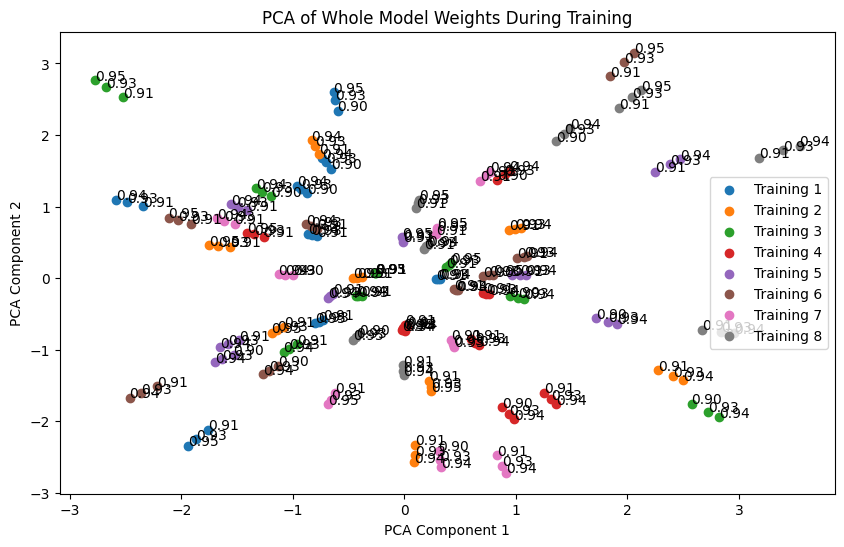

In [11]:
# plot PCA results for layer and whole model
plot_pca(pca_layer_result, accuracy_records, "PCA of Layer Weights During Training (fc1)")
plot_pca(pca_whole_model_result, accuracy_records, "PCA of Whole Model Weights During Training")